# Определение стоимости автомобилей

Описание проекта: cервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля

Цель исследования: нужно построить модель для определения стоимости автомобиля

Ход исследования:

Подготовка данных: загрузка и изучение общей информации из предоставленных датасетов

Предобработка данных: обработка пропущенных значений, удаление дубликатов и т.д.

Исследовательский анализ данных: статистический анализ всех признаков

Корреляционный анализ данных: расчет коэффициентов корреляции для всех признаков

Обучение моделей: обучение моделей пайплайном, выбор лучшей из них, обучение LightGBM

Анализ моделей: анализ времени обучения, времени предсказания и качества моделей

Вывод: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

## Подготовка данных

In [2]:
import sys
!pip install eli5 -q
!pip install -U scikit-learn -q
!"{sys.executable}" -m pip install phik -q

In [3]:
RANDOM_STATE=42
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    cross_validate
)
from sklearn.preprocessing import(
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import(
    mean_squared_error
)

In [4]:
autos=pd.read_csv('/datasets/autos.csv')
autos.info()
autos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Замечу, что в столбцах FuelType, VehicleType и Repaired достаточно много пропусков, поэтому заполню их.

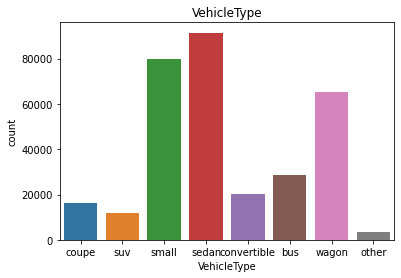

In [5]:
sns.countplot(x='VehicleType', data=autos)
plt.title('VehicleType')
plt.show()

Поменяю пропуски в моделях на наименование бренда машины

In [6]:
autos['Model']=autos['Model'].fillna(autos['Brand'])

Теперь заменю пропуски в типе двигателя на самый часто встречающийся тип у этой машины

In [7]:
autos['VehicleType']=autos['VehicleType'].fillna(autos.groupby('Model')['VehicleType'].transform(lambda x: x.mode()[0] if not x.mode().empty else None))

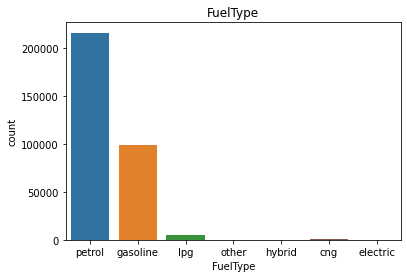

In [8]:
sns.countplot(x='FuelType', data=autos)
plt.title('FuelType')
plt.show()

Аналогично поступлю с пропусками в столбцах Gearbox и FuelType

In [9]:
autos['FuelType']=autos['FuelType'].fillna(autos.groupby('Model')['FuelType'].transform(lambda x: x.mode()[0] if not x.mode().empty else None))

In [10]:
autos['Gearbox']=autos['Gearbox'].fillna(autos.groupby('Model')['Gearbox'].transform(lambda x: x.mode()[0] if not x.mode().empty else None))

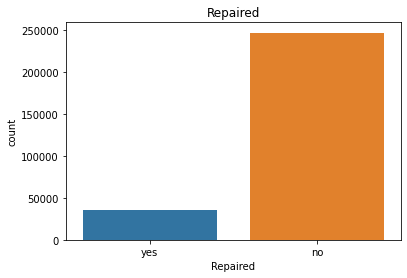

In [11]:
sns.countplot(x='Repaired', data=autos)
plt.title('Repaired')
plt.show()

Поставлю заглушку вместо пропусков в столбец Repaired

In [12]:
autos['Repaired']=autos['Repaired'].fillna('not_stated')

In [13]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Теперь проверю данные на дубликаты

In [14]:
print(sum(autos.duplicated()))
autos=autos.drop_duplicates()
sum(autos.duplicated())

4


0

Удалю наименее информативные признаки: на мой взгляд, это DateCrawled, DateCreated, PostalCode, LastSeen, NumberOfPictures поскольку они не имеют никакого отношения к характеристикам самого автомобиля, а значит не должны влиять на его окончательную стоимость. Признак RegistrationMonth также кажется неинформативным, поскольку у нас уже есть признак RegistrationYear, дающий понять примерный "возраст" автомобиля.

Также необходимо убрать все объявления, в которых год регистрации больше года, в котором было выложено объявление  </div>

In [15]:
aw=pd.DatetimeIndex(autos['DateCreated']).year
print(len(autos))
autos=autos.query("RegistrationYear<=@aw")
autos=autos.query("RegistrationMonth>0 and RegistrationMonth<13")
len(autos)

354365


306170

In [16]:
autos=autos.drop(['DateCrawled','DateCreated','PostalCode', 'LastSeen', 'NumberOfPictures','RegistrationMonth'],axis=1)

Теперь обработаю аномалии

## Статистический анализ данных

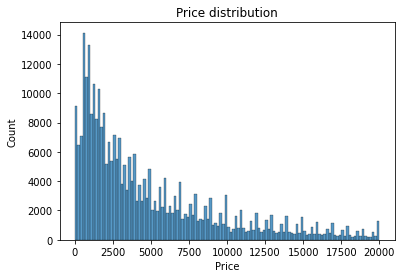

In [17]:
sns.histplot(data=autos,x='Price')
plt.title('Price distribution')
plt.show()

Не уверен, что корректно отдавать автомобиль менее, чем хотя бы за 100 евро, поэтому удалю все подобные объявления, так как для модели они особой ценности не несут.

306170


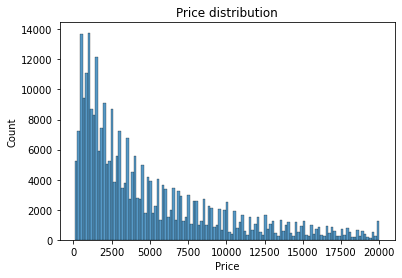

298518

In [18]:
print(len(autos))
autos=autos.query("Price>100")
sns.histplot(data=autos,x='Price')
plt.title('Price distribution')
plt.show()
len(autos)

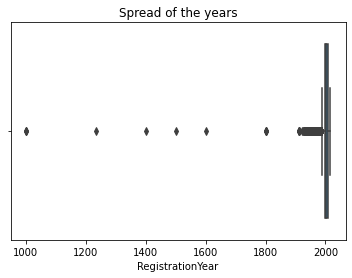

In [19]:
sns.boxplot(data=autos,x='RegistrationYear')
plt.title('Spread of the years')
plt.show()

Осталвю все объявления с годом регистрации с 1990 по 2016 год

298518


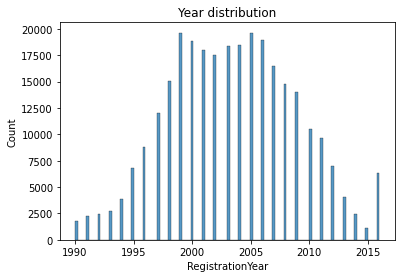

291284

In [20]:
print(len(autos))
autos=autos.query("RegistrationYear>1989 and RegistrationYear<2017")
sns.histplot(data=autos,x='RegistrationYear')
plt.title('Year distribution')
plt.show()
len(autos)

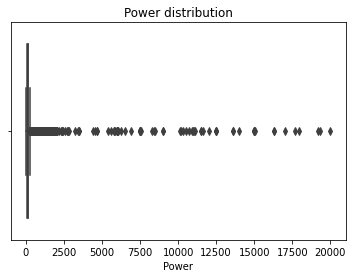

In [21]:
sns.boxplot(data=autos,x='Power')
plt.title('Power distribution')
plt.show()

Восстановлю значение мощности по медиане мощности модели машины

In [22]:
print(len(autos))
autos=autos.query("Power<2200")
autos.loc[autos['Power']==0, 'Power']=autos.groupby('Model')['Power'].transform(lambda x: x.median())
len(autos)

291284


291209

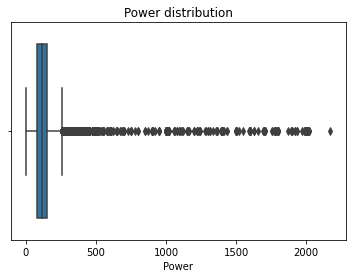

In [23]:
sns.boxplot(data=autos,x='Power')
plt.title('Power distribution')
plt.show()

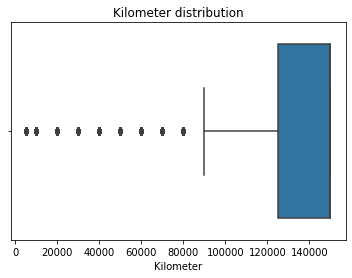

In [24]:
sns.boxplot(data=autos,x='Kilometer')
plt.title('Kilometer distribution')
plt.show()

С километрами все в порядке.

## Корреляционный анализ данных

Теперь изучу корреляцию признаков с помощью матрицы phik

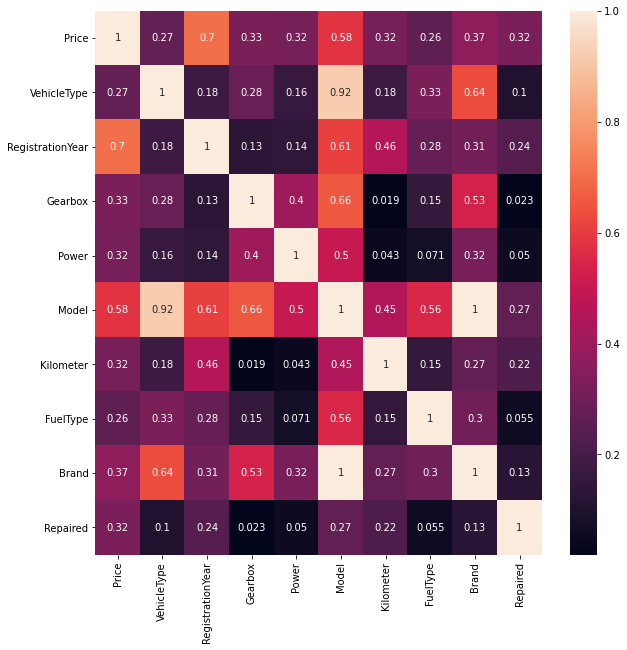

In [25]:
matrix=(autos.phik_matrix(interval_cols=['Price','Kilometer','Power','RegistrationYear']))
plt.figure(figsize=(10,10))
sns.heatmap(matrix,annot=True)
plt.show()

Замечу, что признаки Model и Brand имеют корреляцию 1, поскольку у определенных брендов есть определенные модели. Model и VehicleType также очень сильно связаны, так как модели характеризуются определенными двигателями. Скоре всего, стоит удалить признак brand, поскольку признак model гораздо более информативен

С целевым признаком высоко коррелирует признак RegistrationYear, что логично, потому что за более новые версии владельцы требуют больше. Также умеренно с Price коррелирует Brand, что тоже достаточно логично, существуют премиум бренды, но также есть и дешевый сегмент.

In [26]:
autos=autos.drop(['Brand'],axis=1)

После избавления от аномалий мы лишились примерно 10% изначальных данных, что в целом терпимо, зато данные будут адекватными, что поможет модели лучше научиться предсказывать стоимость. Многие люди в объявлениях завышают год регистрации автомобиля, чтобы попытаться продать свою машину подороже. 
    
По корреляции признаков можно сделать вывод, что на цену машины сильнее всего влияет бренд и год регистрации, следовательно люди больше всего ценят марку машины и её возраст. Также были обнаружена мультиколлинеарность между признаками(например, VehicleType и Model, а также Brand и Model)
    
Были удалены признаки DateCrawled, DateCreated, PostalCode, LastSeen, NumberOfPictures, RegistrationMonth, а также Brand для более продуктивного обучения моделей. 

## Обучение моделей

In [27]:
y=autos['Price']
X=autos.drop('Price',axis=1)
ohe_pipe=Pipeline([
    ('simpleImputerohe',SimpleImputer(missing_values=np.nan ,strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first',handle_unknown='ignore'))
])
num_cols=['RegistrationYear','Power','Kilometer']
cat_cols=['VehicleType','Gearbox','FuelType','Model','Repaired']
X_train,X_test,y_train,y_test=train_test_split(
X,
y,
test_size=0.2,
random_state=RANDOM_STATE)

In [28]:
data_preprocessor=ColumnTransformer([
    ('ohe',ohe_pipe,cat_cols),
    ('num',StandardScaler(),num_cols)],
    remainder='passthrough'
)
pipe_final=Pipeline([
    ('preprocessor',data_preprocessor),
    ('models',DecisionTreeRegressor())
])
param_distributions=[
{
    'models':[DecisionTreeRegressor()],
    'models__max_depth':range(1,5)
},
{
    'models':[LinearRegression()],
    'preprocessor__num':[StandardScaler(),MinMaxScaler()]
}]
grid=GridSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring='neg_mean_squared_error',
    error_score='raise',
    n_jobs=-1,
    verbose=3,
    refit='recall'
)


In [29]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-13156247.480 total time=   0.7s
[CV 2/5] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-13041973.605 total time=   0.7s
[CV 3/5] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-13246257.839 total time=   0.7s
[CV 4/5] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-12893674.718 total time=   0.7s
[CV 5/5] END models=DecisionTreeRegressor(), models__max_depth=1;, score=-12867284.200 total time=   0.7s
[CV 1/5] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-9914822.193 total time=   0.8s
[CV 2/5] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-9894182.401 total time=   0.8s
[CV 3/5] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-9973508.399 total time=   0.8s
[CV 4/5] END models=DecisionTreeRegressor(), models__max_depth=2;, score=-9758740.471 total tim

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputerohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['VehicleType',
                                                                          'Gearbox',
                                                                          'FuelType',
                                                                          'Model',
                                                                          'Repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer'])])),
                                       ('models', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor()],
                          'models__max_depth': range(1, 5)},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             refit='recall', scoring='neg_mean_squared_error', verbose=3)

In [30]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_) 
print ('Метрика лучшей модели на кросс-валидационной выборке:', (grid.best_score_*-1)**0.5)
print('Среднее время обучения лучшей модели: ',grid.cv_results_['mean_fit_time'][grid.best_index_],' сек')
print('Среднее время предсказания лучшей модели: ',grid.cv_results_['mean_score_time'][grid.best_index_],' сек')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputerohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Model',
                                                   'Repaired']),
                                                 ('num', StandardScaler(),
                                                  ['Re

Теперь обучу модель градиентного бустинга LGBMRegressor

In [31]:
for cat in cat_cols:
    X_train[cat] = X_train[cat].astype('category')
model = LGBMRegressor()

In [32]:
cv_results=cross_validate(model,X_train,y_train,cv=5,n_jobs=-1,scoring='neg_mean_squared_error',verbose=3)
print('Среднее время обучения: ',cv_results['fit_time'].mean(),' сек.')
print('Среднее время предсказания: ',cv_results['score_time'].mean(),' сек.')
cv_results['test_score']=(cv_results['test_score']*-1)**0.5
print('Средняя метрика RMSE: ',cv_results['test_score'].mean())

[CV] END ................................, score=-2512375.893 total time=   5.3s
[CV] END ................................, score=-2473553.568 total time=   6.5s
[CV] END ................................, score=-2532844.603 total time=   5.5s
[CV] END ................................, score=-2469506.717 total time=   5.3s
[CV] END ................................, score=-2443840.421 total time=   5.7s
Среднее время обучения:  5.10620756149292  сек.
Среднее время предсказания:  0.5437608242034913  сек.
Средняя метрика RMSE:  1576.8075150873187


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.3s finished


Сравнив результаты моделей на кросс-валидационной выборке, можно сказать, что лучшая из моделей, не использующая градиентный бустинг, справляется с предсказанием почти в два раза хуже, чем модель LGBMRegressor, однако последняя обучается гораздо дольше(0.8 сек против 5). Время предсказания у моделей отличается не так сильно и достаточно мало у обеих.
    
Поскольку предсказания LGBM модели гораздо точнее, то логично будет выбрать именно ее, ведь заказчику вряд ли понадобится часто промахивающаяся модель, пусть и быстро обучаемая.

In [36]:
model.fit(X_train, y_train, categorical_feature=cat_cols)
for cat in cat_cols:
    X_test[cat] = X_test[cat].astype('category')
y_pred2=model.predict(X_test)
print('Метрика RMSE на тестовой выборке: ',mean_squared_error(y_test,y_pred2)**0.5)

Метрика RMSE на тестовой выборке:  1559.5757820607655


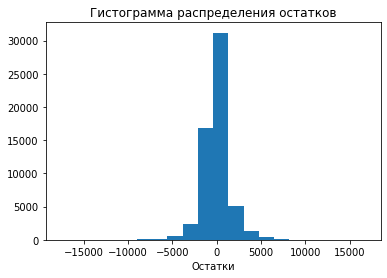

In [34]:
residuals = y_test - y_pred2
plt.hist(x=residuals,bins=20)
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
plt.show()

         true          pred
268894    650    742.864667
196203   2999   3245.353697
179542   4500   3708.592622
134693   5200   3784.646750
34219    3790   4713.974823
...       ...           ...
99297    1500   1708.912599
154760   9999  10732.002137
173468    950   1662.148549
111769   2800   2522.662641
52759   18200  16917.447592

[58242 rows x 2 columns]


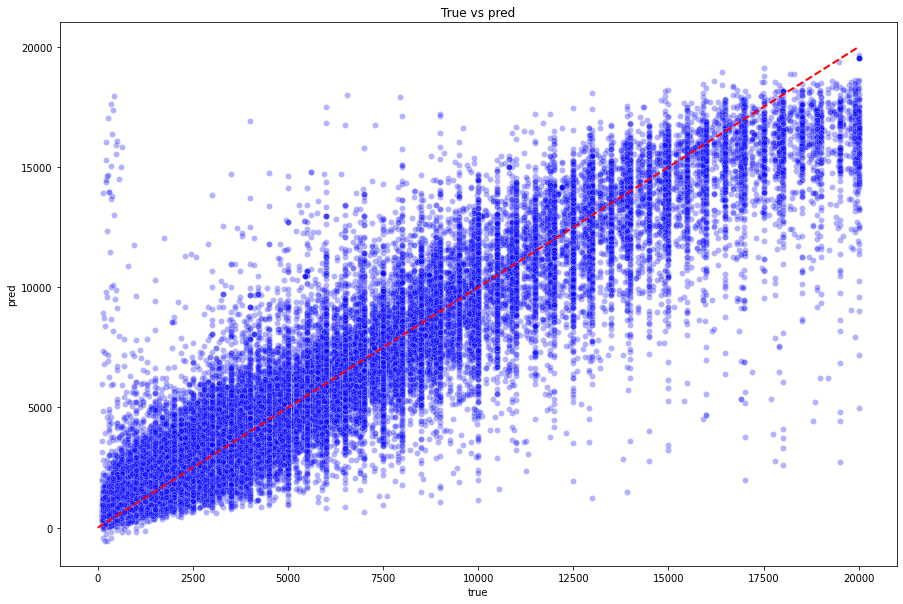

In [35]:
meow=pd.DataFrame()
meow['true']=y_test
meow['pred']=y_pred2
print(meow)
plt.figure(figsize=(15,10))
sns.scatterplot(x='true', y='pred', data=meow, color='blue', alpha=0.3)
plt.title('True vs pred')
max_value = max(meow['true'].max(), meow['pred'].max())
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', linewidth=2)
plt.show()

## Анализ моделей

Можно заметить, что модель LightGBMRegressor показывает лучшую метрику по сравнению с DecisionTreeRegressor. Время на предсказание у моделей почти одинаковое, а вот время обучения у модели с градиентным бустингом ощутимо больше: более 3 секунд по сравнению с 1 сек. Однако LightGBMRegressor все равно справляется с поставленной задачей гораздо лучше, а 3-5 секунд- это не такое большое время, которое могло бы быть, поэтому я считаю именно ее лучшей моделью

Подводя итог, можно сделать вывод, что модель, использующая градиентный бустинг справляется с задачей лучше и имеет лучшую метрику. На этапе обработки пропусков пришлось заполнять их на основе значений других столбцов. Также необходимо было обработать аномалии и восстановить нормальные значения по другим столбцам. Некоторые признаки пришлось удалить ввиду их бесполезности для обучения модели.
    
Было обучено 3 модели:CatBoostRegressor, DecisionTreeRegressor и LinearRegression, из них наилучшую метрику RMSE имеет перва модель-1558 на тестовой выборке, гистограмма распределения остатков имеет нормальное распределение около 0, а график рассеяния таргета и предсказаний показывает, что модель часто занижает стоимость машины, особенно если машина стоит более 10000 евро